In [1]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from LSTM.plot_utils import *
from LSTM.model import *
from LSTM.dataset import *
from LSTM.evaluate import *

In [2]:
os.listdir('./sample_data/')

['Aust-Mine-Prod-v01.4b-Tab08-Graph-Silver.pdf',
 'Aust-Mine-Prod-v01.4b-Tab06-Graph-Gold.pdf',
 'Aust-Mine-Prod-v01.4b-Tab09-Graph-Lead.pdf',
 'Aust-Mine-Prod-v01.4b-Tab07-Graph-Copper.pdf',
 'Aust-Mine-Prod-v01.4b-Tab05-Sn-Fields.csv',
 'Aust-Mine-Prod-v01.4b-Tab11-Graph-Nickel.pdf',
 'Aust-Mine-Prod-v01.4b-Tab10-Graph-Zinc.pdf',
 'Aust-Mine-Prod-v01.4b-Master.xlsx',
 'Aust-Mine-Prod-v01.4b-Tab04-Annual-Data.csv',
 'Aust-Mine-Prod-v01.4b-Tab06-11-Graphs.pptx',
 'Aust-Mine-Prod-v01.4b-Tab03-Mine-by-Mine.csv',
 'Aust-Mine-Prod-v01.4b-Tab01-Notes.csv',
 'Aust-Mine-Prod-v01.4b-Tab02-Summary.csv']

## Copper production data
Source: A Comprehensive dataset for Australian mine production 1799 to 2021 
(https://www.nature.com/articles/s41597-023-02275-z#Sec3)

License: Creative Commons Attribution 4.0 International (CC BY 4.0). Free to share, copy, redistribute, adapt, and build upon the data, even for commercial purposes, as long as appropriate credit is given to the original authors.

In [3]:
## Read the data
cu_cols = [0] + list(range(59,68))
cu_df = pd.read_csv('./sample_data/Aust-Mine-Prod-v01.4b-Tab04-Annual-Data.csv', skiprows=7, usecols=cu_cols)

## define dataframe headers
cu_header = cu_df.iloc[[0,1]].apply(lambda x: '_'.join(x.dropna().astype(str)), axis=0).to_list()
cu_header = [column.lower().replace(' ', '_').replace('.', '') for column in cu_header]
cu_df = cu_df.drop(index=[0,1]).reset_index(drop=True)
cu_df.columns = cu_header
cu_df.rename(columns={'australia_$/t_cu':'price_t'}, inplace=True)

## typecasting to floats
cu_df = cu_df.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce'))

## set year as the new index
cu_df.set_index(keys=['year'], inplace=True)

## handling missing values
cu_df.dropna(how="all", inplace=True)
cu_df.ffill(inplace=True) # forward-fill for the years where older values are available
cu_df.fillna(0, inplace=True) # zeroes for years before the first recorded value
cu_df.head(3)

,qld_t_cu,nsw_t_cu,vic_t_cu,tas_t_cu,sa_t_cu,wa_t_cu,nt_t_cu,australia_t_cu,price_t
year,,,,,,,,,
1842,0.0,0.0,0.0,0.0,2.03,0.0,0.0,2.03,101.38
1843,0.0,0.0,0.0,0.0,1.02,0.0,0.0,1.02,250.00
1844,0.0,0.0,0.0,0.0,55.90,0.0,0.0,55.90,143.16


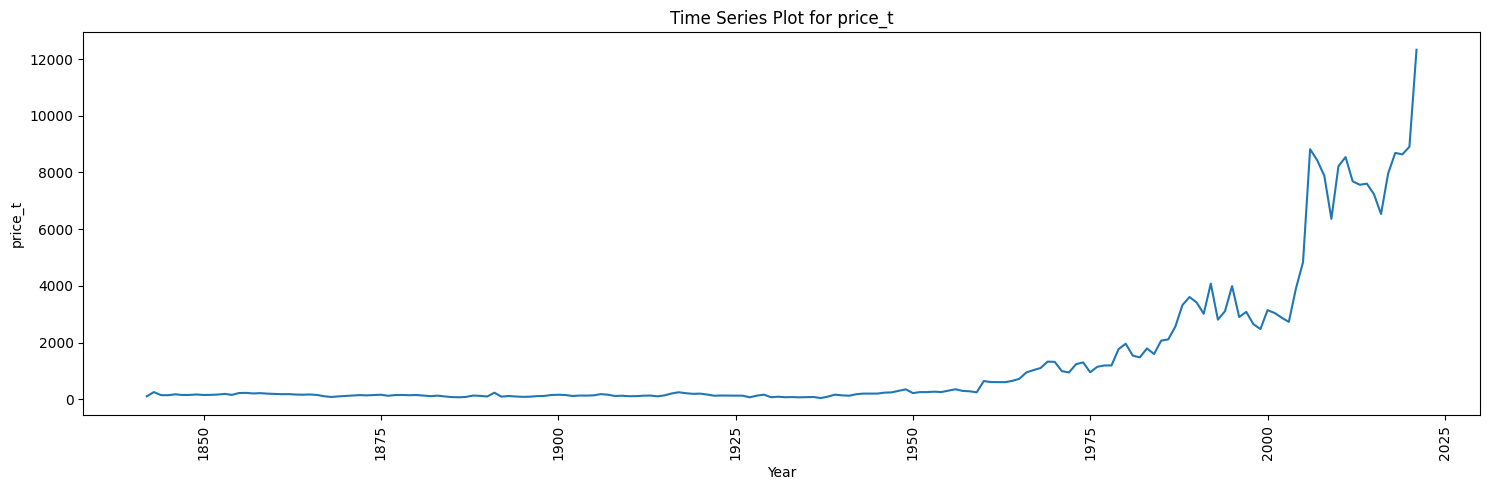

In [4]:
plot_time_series(cu_df, "price_t")

In [5]:
cu_df.isna().sum()

qld_t_cu          0
nsw_t_cu          0
vic_t_cu          0
tas_t_cu          0
sa_t_cu           0
wa_t_cu           0
nt_t_cu           0
australia_t_cu    0
price_t           0
dtype: int64

In [6]:
# add a few lag features
cu_df['australia_t_cu_lag3'] = cu_df['australia_t_cu'].shift(3)
cu_df['australia_t_cu_lag5'] = cu_df['australia_t_cu'].shift(5)
cu_df['australia_t_cu_lag7'] = cu_df['australia_t_cu'].shift(7)

## Modelling
Let's try to model the price of the copper (per tonne) on the supply factors namely the per year production for the copper in Australia. We will try to test if there is observable relation between overall sales in Australia and price of copper. If so, we will uncover any linear correlation between the two variables.

In [7]:
# defining training and testing data
train_start_year, train_end_year = 1946, 2016

train_df = cu_df.loc[train_start_year:train_end_year, ]
test_df = cu_df.loc[train_end_year:, ]
print(f"Training dataset: {train_df.shape}")
print(f"Testing dataset: {test_df.shape}")

Training dataset: (71, 12)
Testing dataset: (6, 12)


#### a. Price on Production (Australia)

In [8]:
train_cols=['australia_t_cu']
target_col=['price_t']

feat_scaler=MinMaxScaler()
target_scaler=MinMaxScaler()

X_train_tensor, y_train_tensor, feat_scaler, target_scaler = prepare_train_data(
    df=train_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5
)

X_test_tensor, y_test_tensor = prepare_test_data(
    df=test_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5,
    scale_target=False
)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([66, 5, 1]) torch.Size([66, 1])
torch.Size([1, 5, 1]) torch.Size([1, 1])


In [9]:
input_size = X_train_tensor.shape[2]  # Number of production features (columns)
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting price
num_layers = 2   # Number of LSTM layers

simple_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
print(simple_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

num_epochs = 200
for epoch in range(num_epochs):
    simple_model.train()
    
    # Forward pass
    outputs = simple_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Loss: 0.1445
Epoch [20/200], Loss: 0.1346
Epoch [30/200], Loss: 0.1252
Epoch [40/200], Loss: 0.1161
Epoch [50/200], Loss: 0.1073
Epoch [60/200], Loss: 0.0990
Epoch [70/200], Loss: 0.0913
Epoch [80/200], Loss: 0.0845
Epoch [90/200], Loss: 0.0790
Epoch [100/200], Loss: 0.0749
Epoch [110/200], Loss: 0.0721
Epoch [120/200], Loss: 0.0700
Epoch [130/200], Loss: 0.0682
Epoch [140/200], Loss: 0.0662
Epoch [150/200], Loss: 0.0641
Epoch [160/200], Loss: 0.0618
Epoch [170/200], Loss: 0.0593
Epoch [180/200], Loss: 0.0565
Epoch [190/200], Loss: 0.0535
Epoch [200/200], Loss: 0.0502


Mean Squared Error (MSE): 3696885.25
Root mean Squared Error (MSE): 1922.7286376953125


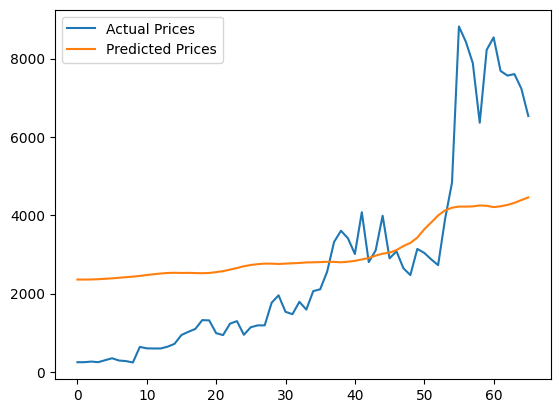

In [10]:
mse_a, rmse_a = evaluate_training(model=simple_model,
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        target_scaler=target_scaler)

#### b. Price on Production (States in Australia)

In [11]:
train_cols=[ 'qld_t_cu', 'nsw_t_cu', 'vic_t_cu', 'tas_t_cu', 'sa_t_cu', 'wa_t_cu', 'nt_t_cu']
target_col=['price_t']

feat_scaler=MinMaxScaler()
target_scaler=MinMaxScaler()

X_train_tensor, y_train_tensor, feat_scaler, target_scaler = prepare_train_data(
    df=train_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5
)

X_test_tensor, y_test_tensor = prepare_test_data(
    df=test_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5,
    scale_target=False
)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([66, 5, 7]) torch.Size([66, 1])
torch.Size([1, 5, 7]) torch.Size([1, 1])


In [12]:
input_size = X_train_tensor.shape[2]  # Number of production features (columns)
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting price
num_layers = 2   # Number of LSTM layers

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
simple_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
print(simple_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

num_epochs = 200
for epoch in range(num_epochs):
    simple_model.train()
    
    # Forward pass
    outputs = simple_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Loss: 0.2060
Epoch [20/200], Loss: 0.1914
Epoch [30/200], Loss: 0.1771
Epoch [40/200], Loss: 0.1628
Epoch [50/200], Loss: 0.1482
Epoch [60/200], Loss: 0.1331
Epoch [70/200], Loss: 0.1174
Epoch [80/200], Loss: 0.1012
Epoch [90/200], Loss: 0.0850
Epoch [100/200], Loss: 0.0699
Epoch [110/200], Loss: 0.0574
Epoch [120/200], Loss: 0.0490
Epoch [130/200], Loss: 0.0443
Epoch [140/200], Loss: 0.0407
Epoch [150/200], Loss: 0.0369
Epoch [160/200], Loss: 0.0331
Epoch [170/200], Loss: 0.0294
Epoch [180/200], Loss: 0.0260
Epoch [190/200], Loss: 0.0229
Epoch [200/200], Loss: 0.0203


Mean Squared Error (MSE): 1484138.75
Root mean Squared Error (MSE): 1218.2523193359375


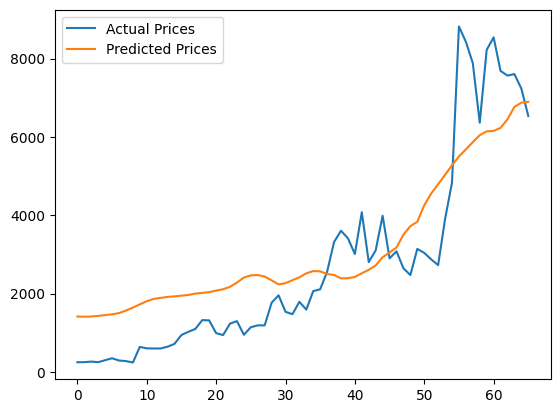

In [13]:
mse_b, rmse_b = evaluate_training(model=simple_model,
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        target_scaler=target_scaler)

The Mean squared error (MSE) have dropped by a third compared to when the model was trained only on single variable of country-wide production of copper.

#### c. Price on Production (Australia) with lags

In [14]:
train_cols=['australia_t_cu', 'australia_t_cu_lag3', 'australia_t_cu_lag5', 'australia_t_cu_lag7']
target_col=['price_t']

feat_scaler=MinMaxScaler()
target_scaler=MinMaxScaler()

X_train_tensor, y_train_tensor, feat_scaler, target_scaler = prepare_train_data(
    df=train_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5
)

X_test_tensor, y_test_tensor = prepare_test_data(
    df=test_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5,
    scale_target=False
)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([66, 5, 4]) torch.Size([66, 1])
torch.Size([1, 5, 4]) torch.Size([1, 1])


In [15]:
input_size = X_train_tensor.shape[2]  # Number of production features (columns)
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting price
num_layers = 2   # Number of LSTM layers

simple_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
print(simple_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

num_epochs = 200
for epoch in range(num_epochs):
    simple_model.train()
    
    # Forward pass
    outputs = simple_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Loss: 0.1461
Epoch [20/200], Loss: 0.1344
Epoch [30/200], Loss: 0.1236
Epoch [40/200], Loss: 0.1135
Epoch [50/200], Loss: 0.1039
Epoch [60/200], Loss: 0.0945
Epoch [70/200], Loss: 0.0854
Epoch [80/200], Loss: 0.0766
Epoch [90/200], Loss: 0.0683
Epoch [100/200], Loss: 0.0609
Epoch [110/200], Loss: 0.0545
Epoch [120/200], Loss: 0.0493
Epoch [130/200], Loss: 0.0447
Epoch [140/200], Loss: 0.0403
Epoch [150/200], Loss: 0.0357
Epoch [160/200], Loss: 0.0311
Epoch [170/200], Loss: 0.0265
Epoch [180/200], Loss: 0.0223
Epoch [190/200], Loss: 0.0186
Epoch [200/200], Loss: 0.0155


Mean Squared Error (MSE): 1131010.0
Root mean Squared Error (MSE): 1063.489501953125


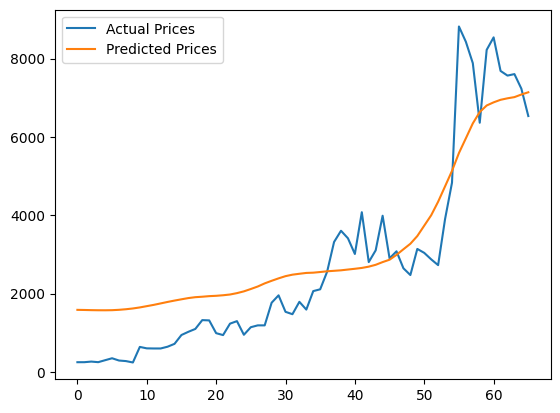

In [16]:
mse_c, rmse_c = evaluate_training(model=simple_model,
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        target_scaler=target_scaler)

In [17]:
print(f"Percentage change in MSE from a. to b.: {np.round(((mse_b-mse_a)/mse_a)*100, 2)}%")
print(f"Percentage change in MSE from b. to c.: {np.round(((mse_c-mse_b)/mse_b)*100, 2)}%")

Percentage change in MSE from a. to b.: -59.85%
Percentage change in MSE from b. to c.: -23.79%
